### Attention

Let $D$ denote a sequence of **keys** and **values**: $D=\{(k_1,v_1),...,(k_m,v_m)\}$. Let $\mathbf{q}$ be a **query**. The **attention** over $D$ is
\begin{equation}
    \text{Attention}(\mathbf{q},D) = \sum_{i=1}^{m}{\alpha(\mathbf{q},\mathbf{k}_i)\mathbf{v_i}},
\end{equation}
where $\{\alpha(\mathbf{q},\mathbf{k_i})\}_{i=1}^{m}$ are <font color='red'>scalar attention weights</font>. <br>
Typically it is good to have all weights (1) are nonnegative and (2) add up to 1. A common strategy to ensure this is to apply **softmax** operation on a distance measure between $\mathbf{q}$ and $\mathbf{k}_i$, say $a$. 

### Dot product attention

To ensure that the variance of the dot product still remians 1 regardless of vector length, we use the scaled dot-product attention scoring function. Write
\begin{equation}
    a(\mathbf{q},\mathbf{k_i})=\mathbf{q}^{T} \mathbf{k}_i / \sqrt{d}.
\end{equation}
Then
\begin{equation}
    \alpha(\mathbf{q},\mathbf{k}_i)=\text{softmax}{(a(\mathbf{q},\mathbf{k}_i))}=\frac{\exp{\mathbf{q}^{T} \mathbf{k}_i / \sqrt{d}}}{\sum_{j}\exp(\mathbf{q}^{T} \mathbf{k}_j / \sqrt{d})}.
\end{equation}

**Fact**. Assume that all the elements of the query $\mathbf{q}$ and the key $\mathbf{k}_i$ are independent and identically drawn random variables with zero mean and unit variance. Then $\mathbf{q}^{T}\mathbf{k}_i$ has zero mean and a variance of $d$. To ensure that the variance of the dot product still remians 1 regardless of vector length, we rescale the dot-product by $1/\sqrt{d}$.

### Kernel regression: Nadaraya–Watson kernel estimator

Let $h > 0$ be the bandwidth. The Nadaraya–Watson kernel estimator is defined by
\begin{equation}
    f(\mathbf{q}) = \sum_{i}{v_i\frac{K(\frac{\mathbf{q} - \mathbf{k}_i)}{h}}{\sum_j{K(\frac{\mathbf{q} - \mathbf{k}_j}{h})}}}.
\end{equation}

Observations
1. <font color='blue'>typically</font> $\mathbf{q}$ and $\mathbf{k}_j$ have the same shape
2. no. of keys equals no. of values
3. dim of $v_i$ can be any

In [1]:
import math

from d2l import torch as d2l
import torch
from torch import nn

### Masked Softmax Operation

To be able to deal with sequences of different lengths, we pad shorter sequences with dummy tokens. <br>
For instance, assume that we have the following three sentences: <br>
Dive into Deep Learning <br>
Learn to code \<blank\> <br>
Hello world \<blank\> \<blank\> <br>

We do **not** want blanks in our attention model. We simply need to limit
\begin{equation}
    \sum_{i=1}^{m}{\alpha(\mathbf{q},\mathbf{k}_i)v_i} = \sum_{i=1}^{l}{\alpha(\mathbf{q},\mathbf{k}_i)v_i},
\end{equation}
for however long $l \leq n$ the actual sentence is.

In [2]:
def masked_softmax(X, valid_lens):
    """
    Perform softmax operation by masking elements on the last axis.

    :param X: 3D tensor
    :param valid_lens: 1D or 2D tensor
    """

    def _sequence_mask(X, valid_len, value=0):
        maxlen = X.size(1)
        mask = torch.arange((maxlen), dtype=torch.float32,
                            device=X.device)[None, :] < valid_len[:, None]
        X[~mask] = value
        return X

    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
    if valid_lens.dim() == 1:
        valid_lens = torch.repeat_interleave(valid_lens, shape[1])
    else:
        valid_lens = valid_lens.reshape(-1)
    # On the last axis, replace masked elements with a very large negative
    # value, whose exponentiation outputs 0
    X = _sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
    return nn.functional.softmax(X.reshape(shape), dim=-1)

In [3]:
class DotProductAttention(nn.Module):
    """Scaled dot product attention."""

    def __init__(self, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens=None):
        """
        :param queries: (batch_size, no. of queries, d)
        :param keys: (batch_size, no. of key-value pairs, d)
        :param values: (batch_size, no. of key-value pairs, value dimension)
        :param valid_lens: (batch_size,) or (batch_size, no. of queries)
        """
        d = queries.shape[-1]
        # Swap the last two dimensions of keys with keys.transpose(1, 2)
        scores = torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(d)
        print(f'queries.shape, keys.transpose(1, 2).shape: {queries.shape, keys.transpose(1, 2).shape}')
        print(f'scores.shape: {scores.shape}')
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [4]:
torch.manual_seed(0)

batch_size = 2
dim_qk, dim_val, num_kv = 2, 4, 10

queries = torch.normal(0, 1, (batch_size, 1, dim_qk))
keys = torch.normal(0, 1, (batch_size, num_kv, dim_qk))
values = torch.normal(0, 1, (batch_size, num_kv, dim_val))
valid_lens = torch.tensor([2, 6])
attention = DotProductAttention(dropout=0.5)
attention.eval()

DotProductAttention(
  (dropout): Dropout(p=0.5, inplace=False)
)

In [5]:
queries.shape, keys.shape, values.shape

(torch.Size([2, 1, 2]), torch.Size([2, 10, 2]), torch.Size([2, 10, 4]))

In [6]:
queries

tensor([[[ 1.5410, -0.2934]],

        [[-2.1788,  0.5684]]])

In [7]:
keys

tensor([[[-0.3561,  0.4372],
         [ 0.4913, -0.2041],
         [-0.0885,  0.5239],
         [-0.6659,  0.8504],
         [-1.0438, -1.3453],
         [ 0.7854,  0.9928],
         [-0.1932, -0.3090],
         [ 0.5026, -0.8594],
         [ 0.4681, -0.1577],
         [ 1.4437,  0.2660]],

        [[ 0.1665,  0.8744],
         [-0.1435, -0.1116],
         [-0.6731,  0.8728],
         [ 1.0554,  0.1778],
         [-0.2303, -0.3918],
         [ 0.5433, -0.3952],
         [-0.4462,  0.7440],
         [ 1.5210,  3.4105],
         [-1.5312, -1.2341],
         [ 1.8197, -0.5515]]])

In [8]:
values

tensor([[[-5.6925e-01,  9.1997e-01,  1.1108e+00,  1.2899e+00],
         [-1.4782e+00,  2.5672e+00, -4.7312e-01,  3.3555e-01],
         [-1.6293e+00, -5.4974e-01, -4.7983e-01, -4.9968e-01],
         [-1.0670e+00,  1.1149e+00, -1.4067e-01,  8.0575e-01],
         [-9.3348e-02,  6.8705e-01, -8.3832e-01,  8.9182e-04],
         [ 8.4189e-01, -4.0003e-01,  1.0395e+00,  3.5815e-01],
         [-2.4600e-01,  2.3025e+00, -1.8817e+00, -4.9727e-02],
         [-1.0450e+00, -9.5650e-01,  3.3532e-02,  7.1009e-01],
         [ 1.6459e+00, -1.3602e+00,  3.4457e-01,  5.1987e-01],
         [-2.6133e+00, -1.6965e+00, -2.2824e-01,  2.7995e-01]],

        [[ 2.4693e-01,  7.6887e-02,  3.3801e-01,  4.5440e-01],
         [ 4.5694e-01, -8.6537e-01,  7.8131e-01, -9.2679e-01],
         [-2.1883e-01, -2.4351e+00, -7.2915e-02, -3.3986e-02],
         [ 9.6252e-01,  3.4917e-01, -9.2146e-01, -5.6195e-02],
         [-6.2270e-01, -4.6372e-01,  1.9218e+00, -4.0255e-01],
         [ 1.2390e-01,  1.1648e+00,  9.2337e-01,  1.3

Let us narrow our focus to a single batch. Each query and key in this context has a dimension of 2. In total, there are 10 (key, value) pairs that we utilize to calculate the weights and then combine them to generate a 4-dimensional prediction.

In [9]:
attention(queries, keys, values, valid_lens)

queries.shape, keys.transpose(1, 2).shape: (torch.Size([2, 1, 2]), torch.Size([2, 2, 10]))
scores.shape: torch.Size([2, 1, 10])


tensor([[[-1.2437,  2.1423, -0.0645,  0.5818]],

        [[-0.0703, -1.3293,  0.4321, -0.0903]]])

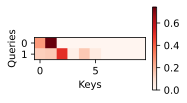

In [10]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, dim_qk, num_kv)), xlabel='Keys', ylabel='Queries')

To handle sequences of varying lengths, we address this by **padding shorter sequences with dummy tokens**. Recall that ```valid_lens = torch.tensor([2, 6])```. The attention weights are set to 0 for anything beyond the 2nd and6thh colum.n

### Additive Attention

When queries $\mathbf{q}$ and keys $\mathbf{k}$ are vectors of <font color='blue'>different dimensionalities</font>, we can <br>
(1) use a matrix to address the mismatch via $\mathbf{q}^⊤ M \mathbf{k}$, <br>
(2) use **additive attention** as the scoring function.

Given a query $\mathbf{q}\in\mathbb{R}^{q}$ and a key $\mathbf{k}\in\mathbb{R}^{k}$ , the additive attention scoring function (Bahdanau et al., 2014) is given by \begin{equation} a(\mathbf{q},\mathbf{k}) = w_v^{T}\tanh{(W_q \mathbf{q} + W_k \mathbf{k})}, \end{equation} where $W_q\in\mathbb{R}^{\textcolor{red}{h} \times q}$, and $W_k \in \mathbb{R}^{\textcolor{red}{h} \times k}$ and $w_v \in \mathbb{R}^\textcolor{red}{h}$ are the **learnable parameters**. This term is <font color='red'>then fed into</font> a **softmax** to ensure both nonnegativity and normalization.<br>
**REMARK**. $\textcolor{red}{h}$ is a hyperparameter in addtive attention.

In [11]:
class AdditiveAttention(nn.Module):
    """Additive attention."""
    def __init__(self, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.LazyLinear(num_hiddens, bias=False)
        self.W_q = nn.LazyLinear(num_hiddens, bias=False)
        self.w_v = nn.LazyLinear(1, bias=False)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, queries, keys, values, valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys)
        # After dimension expansion, shape of queries: (batch_size, no. of
        # queries, 1, num_hiddens) and shape of keys: (batch_size, 1, no. of
        # key-value pairs, num_hiddens). Sum them up with broadcasting
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)
        # There is only one output of self.w_v, so we remove the last
        # one-dimensional entry from the shape. Shape of scores: (batch_size,
        # no. of queries, no. of key-value pairs)
        scores = self.w_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        # Shape of values: (batch_size, no. of key-value pairs, value
        # dimension)
        return torch.bmm(self.dropout(self.attention_weights), values)

Queries, keys and values ```queries, keys = self.W_q(queries), self.W_k(keys)```

![input_emb](figure/attention.png)

Now we create 20-dimensional queries, where the dimensions of the queries are different from the dimensions of the keys.

In [12]:
queries = torch.normal(0, 1, (batch_size, 1, 20))

In [13]:
attention = AdditiveAttention(num_hiddens=8, dropout=0.5)
attention.eval()
print(attention(queries, keys, values, valid_lens))

tensor([[[-0.9728,  1.6512,  0.4077,  0.8662]],

        [[ 0.1012, -0.4399,  0.5887,  0.0335]]], grad_fn=<BmmBackward0>)


C:\Users\billt\PycharmProjects\DeepLearning\dl_venv\lib\site-packages\torch\nn\modules\lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


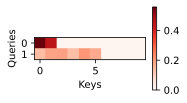

In [14]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, dim_qk, num_kv)), xlabel='Keys', ylabel='Queries')

In [15]:
attention.attention_weights

tensor([[[0.5561, 0.4439, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000]],

        [[0.1353, 0.1798, 0.1825, 0.1343, 0.2001, 0.1679, 0.0000, 0.0000,
          0.0000, 0.0000]]], grad_fn=<SoftmaxBackward0>)